- 参考文献
- Reference:Dai W，Milenkovic O．Subspace pursuit for compressive sensing
- signal reconstruction[J]．IEEE Transactions on Information Theory，

In [1]:
import numpy as np
import math

In [2]:
def cs_sp(y,Phi,K):    
    residual=y  #初始化残差
    (M,N) = Phi.shape
    index = np.array([])
    result=np.zeros((N,1))
    for j in range(K):  #迭代次数
        product=np.fabs(np.dot(Phi.T,residual))         # 计算投影
        top_k_idx = product.argsort(axis=0)[-K:]        # 取最大的K个的序号
        index = np.union1d(index,top_k_idx).astype(int) # 更新候选集
        x = np.zeros((N,1))                             # 算一部分x
        x_temp = np.dot(np.linalg.pinv(Phi[:,index]),y) # 最小二乘  
        x[index] = x_temp                               # 放回去
        index = np.fabs(x).argsort(axis=0)[-K:]         # 取最大的K个的序号
        residual=y-np.dot(Phi,x)                        # 更新残差                    
    return  x, index

In [3]:
# 单次实验
N = 256
M = 128
K = 10
# 生成稀疏信号（高斯）
x = np.random.randn(N,1)
x[:N-K]=0
np.random.shuffle(x)
# 生成高斯随机测量矩阵
Phi=np.random.randn(M,N)/np.sqrt(M)
# 观测信号
y = np.dot(Phi,x)
x_pre, Candidate = cs_sp(y,Phi,K)
# print(Candidate)
error = np.linalg.norm(x-x_pre)/np.linalg.norm(x)
print(error)

8.038920404105852e-16


In [4]:
# 不同稀疏度下的重建概率
N = 256
M = 128
kk = np.linspace(1,60,60,dtype=np.int)
success_rate = np.zeros(60)
success_rate[0]=1
repeat = 200 
for k in kk:
    if k%10==0:
        print(k)
    for i in range(repeat):
        x = np.random.randn(N,1)
        x[:N-k]=0
        np.random.shuffle(x)
        Phi=np.random.randn(M,N)/np.sqrt(M)
        y = np.dot(Phi,x)
        x_pre, Candidate = cs_sp(y,Phi,k)
        error = np.linalg.norm(x-x_pre)/np.linalg.norm(x)
        if error < 1e-4:
            success_rate[k-1]+=1
    success_rate[k-1]/=repeat

10
20
30
40
50
60


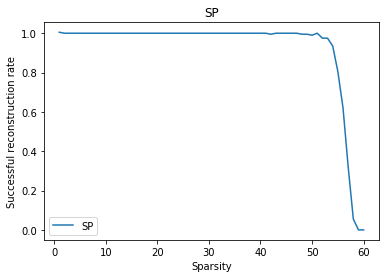

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(kk,success_rate,label='SP')
plt.xlabel('Sparsity')
plt.ylabel('Successful reconstruction rate')
plt.title('SP')
plt.legend()
plt.savefig('SP.jpg')
plt.show()

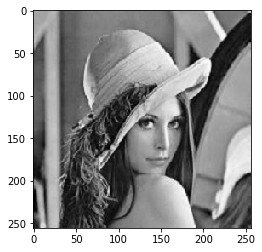

In [6]:
#生成稀疏基DCT矩阵
mat_dct_1d=np.zeros((N,N))
v=range(N)
for k in range(0,N):  
    dct_1d=np.cos(np.dot(v,k*math.pi/N))
    if k>0:
        dct_1d=dct_1d-np.mean(dct_1d)
    mat_dct_1d[:,k]=dct_1d/np.linalg.norm(dct_1d)

from PIL import Image
#读取图像，并变成numpy类型的 array
im = Image.open('imgs/lena.jpg').convert('L') #图片大小256*256
plt.imshow(im,cmap='gray')
N = 256
M = 128
K = 50
im = np.array(im)
# 观测矩阵
Phi=np.random.randn(M,N)/np.sqrt(M)
# 随机测量
img_cs_1d=np.dot(Phi,im)

In [7]:
# 重建
sparse_rec_1d=np.zeros((N,N))   # 初始化稀疏系数矩阵    
Theta_1d=np.dot(Phi,mat_dct_1d)   #测量矩阵乘上基矩阵
for i in range(N):
    if i%32==0:
        print('正在重建第',i,'列。')
    y=np.reshape(img_cs_1d[:,i],(M,1))
    column_rec, Candidate=cs_sp(y,Theta_1d,K) #利用OMP算法计算稀疏系数
    x_pre = np.reshape(column_rec,(N))
    sparse_rec_1d[:,i]=x_pre

正在重建第 0 列。
正在重建第 32 列。
正在重建第 64 列。
正在重建第 96 列。
正在重建第 128 列。
正在重建第 160 列。
正在重建第 192 列。
正在重建第 224 列。


0.1454158750772224

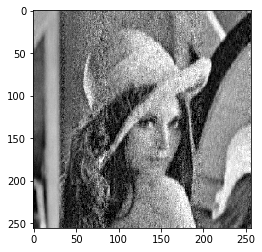

In [8]:
img_rec=np.dot(mat_dct_1d,sparse_rec_1d)          #稀疏系数乘上基矩阵
#显示重建后的图片
img_pre=Image.fromarray(img_rec)
plt.imshow(img_pre,cmap='gray')
error = np.linalg.norm(img_rec-im)/np.linalg.norm(im)
error